In [1]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, Trainer, TrainingArguments, TrainerCallback
from datasets import load_dataset
from pprint import pprint
from tqdm import tqdm
import evaluate
import torch
import logging

import matplotlib.pyplot as plt
import numpy as np

# Suppress specific Hugging Face logging messages
#transformers_logger = logging.getLogger("transformers")
#transformers_logger.setLevel(logging.ERROR)

debugging = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

loss_values = []    # Loss function
epoch_progress = []
exact_match_before = 0     # Exact Match score before distillation
exact_match_after = 0      # Exact Match score after distillation
f1_score_before = 0        # F1 score before distillation
f1_score_after = 0         # F1 score after distillation

# Load the SQuAD dataset
squad = load_dataset("squad")


Device: cuda


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [2]:
# Load teacher model and tokenizer
#teacher_model_name = "csarron/roberta-base-squad-v1"
teacher_model_name = "Dingyun-Huang/roberta-large-squad1" #355M
teacher_model = AutoModelForQuestionAnswering.from_pretrained(teacher_model_name)
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)

# Should do a training pass on SQuAD1.1 to initialise the weights in the Teacher model.
# This will also stop the warning from displaying

# Load student model and tokenizer (smaller version of RoBERTa)
#student_model_name = "distilroberta-base"  # Example smaller model 82M
student_model_name = "csarron/roberta-base-squad-v1"  # Example smaller model 109M
#student_model_name = "deepset/roberta-base-squad2"  # Example smaller model 124M
student_model = AutoModelForQuestionAnswering.from_pretrained(student_model_name)
student_tokenizer = AutoTokenizer.from_pretrained(student_model_name)

config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/75.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/267 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/525 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at csarron/roberta-base-squad-v1 were not used when initializing RobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [3]:
# Define evaluation function
def evaluate_model(model, tokenizer, dataset):
    model.to(device)
    
    metric = evaluate.load("squad")
    predictions = []
    references = []

    for example in tqdm(dataset, desc="Evaluating"):
        # Tokenize inputs
        inputs = tokenizer(
            example["context"], example["question"], truncation=True, padding=True, return_tensors="pt"
        )

        # Move inputs to the same device as the model
        inputs = {key: value.to(device) for key, value in inputs.items()}
        
        # Get model outputs
        outputs = model(**inputs)
        start_logits, end_logits = outputs.start_logits, outputs.end_logits
        start_idx = torch.argmax(start_logits, dim=-1).item()
        end_idx = torch.argmax(end_logits, dim=-1).item()
        
        # Decode prediction
        prediction = tokenizer.decode(inputs["input_ids"][0][start_idx:end_idx + 1])
        
        # Append to predictions
        predictions.append({
            "id": example["id"],
            "prediction_text": prediction
        })

        # Append to references (ground truth)
        references.append({
            "id": example["id"],
            "answers": example["answers"]
        })

    # Compute metrics
    result = metric.compute(predictions=predictions, references=references)
    
    return result

In [4]:
def preprocess_validation_data(example):
    # Tokenize context and question
    inputs = student_tokenizer(
        example["context"],
        example["question"],
        truncation=True,
        padding="max_length",
        max_length=384,
    )
    return inputs

In [5]:

validation_dataset = squad["validation"]

# Evaluate teacher model
print("Teacher Model Evaluation")
result = evaluate_model(teacher_model, teacher_tokenizer, validation_dataset)
print(f"Exact Match: {result['exact_match']:.2f}%")
print(f"F1 Score: {result['f1']:.2f}%\n")

# Evaluate student model on validation set (before distillation)
print("Student Model Evaluation (Before Distillation)")
result = evaluate_model(student_model, student_tokenizer, validation_dataset)
print(f"Exact Match: {result['exact_match']:.2f}%")
print(f"F1 Score: {result['f1']:.2f}%\n")

# Save the results for use in Graphs
exact_match_before = result['exact_match']
f1_score_before = result['f1']

Teacher Model Evaluation


Evaluating: 100%|██████████| 10570/10570 [01:48<00:00, 97.63it/s] 


Exact Match: 82.50%
F1 Score: 89.19%

Student Model Evaluation (Before Distillation)


Evaluating: 100%|██████████| 10570/10570 [01:00<00:00, 174.72it/s]


Exact Match: 57.20%
F1 Score: 64.44%



In [6]:
# Prepare data for distillation
def preprocess_data(example):

    # Move teacher model to appropriate device
    teacher_model.to(device)
    
    # Tokenize context and question
    inputs = teacher_tokenizer(
        example["context"], 
        example["question"], 
        truncation=True, 
        padding="max_length", 
        max_length=384,
        return_tensors="pt"
    )

    # Move inputs to the same device as the teacher model
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Get logits from the teacher model
    with torch.no_grad():
        outputs = teacher_model(**inputs)
    
    # Add teacher logits to the example
    example["input_ids"] = inputs["input_ids"][0].cpu().tolist()
    example["attention_mask"] = inputs["attention_mask"][0].cpu().tolist()
    example["start_logits"] = outputs.start_logits[0].cpu().tolist()
    example["end_logits"] = outputs.end_logits[0].cpu().tolist()
    
    return example

if debugging: 
    train_dataset = squad["train"].select(range(10000)).map(preprocess_data)
else:
    train_dataset = squad["train"].map(preprocess_data)    

# Apply preprocessing to validation dataset
validation_set = validation_dataset.map(preprocess_validation_data, batched=True)

# Define training arguments for student model
training_args = TrainingArguments(
    output_dir="./trained_student",
    logging_steps=10,          # Log every 10 steps need when using small datasets for testing
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=12,
    weight_decay=0.01,
    save_total_limit=2,
    save_strategy="epoch",
    remove_unused_columns=False,
)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [7]:
# Custom progress callback
class TeacherTrainingProgress(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs:
            loss_values.append(logs['loss'])
            epoch_progress.append(logs['epoch'])
            

In [8]:
# Define custom loss function for knowledge distillation
class DistillationTrainer(Trainer):    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Custom loss function for knowledge distillation.
        """
        
        # Forward pass
        outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
        
        # Compute KL Divergence loss between teacher and student logits
        start_loss = torch.nn.functional.kl_div(
            torch.nn.functional.log_softmax(outputs.start_logits, dim=-1),
            torch.nn.functional.softmax(inputs["start_logits"], dim=-1),
            reduction="batchmean"
        )
        end_loss = torch.nn.functional.kl_div(
            torch.nn.functional.log_softmax(outputs.end_logits, dim=-1),
            torch.nn.functional.softmax(inputs["end_logits"], dim=-1),
            reduction="batchmean"
        )
        
        # Average the start and end losses
        loss = (start_loss + end_loss) / 2
        
        return (loss, outputs) if return_outputs else loss

In [9]:
class FullyCustomDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        # Filter out non-tokenized fields before padding
        tokenized_features = [
            {k: v for k, v in f.items() if k in ["input_ids", "attention_mask", "token_type_ids"]}
            for f in features
        ]

        # Dynamically pad input_ids and attention_mask using the tokenizer
        batch = self.tokenizer.pad(
            tokenized_features,
            padding=True,
            max_length=None,
            return_tensors="pt",
        )

        # Add custom fields (e.g., start_logits and end_logits) to the batch
        if "start_logits" in features[0]:
            batch["start_logits"] = torch.tensor([f["start_logits"] for f in features], dtype=torch.float32)
        if "end_logits" in features[0]:
            batch["end_logits"] = torch.tensor([f["end_logits"] for f in features], dtype=torch.float32)

        return batch

In [10]:
data_collator = FullyCustomDataCollator(tokenizer=student_tokenizer)

In [11]:
# Train the student model using the custom trainer
trainer = DistillationTrainer(
    model=student_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_set,
    data_collator=data_collator,
    callbacks=[TeacherTrainingProgress()]
)

train_result = trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10,0.914000
20,0.523800
30,0.398200
40,0.373800
50,0.375400
60,0.356000
70,0.388100
80,0.343500
90,0.371800
100,0.294200


In [12]:
# Evaluate student model on validation set after distillation
print("Student Model Evaluation after Distillation")
result = evaluate_model(student_model, student_tokenizer, validation_dataset)
print(f"Exact Match: {result['exact_match']:.2f}%")
print(f"F1 Score: {result['f1']:.2f}%\n")

# Save the results for use in Graphs
exact_match_after = result['exact_match']
f1_score_after = result['f1']

Student Model Evaluation after Distillation


Evaluating: 100%|██████████| 10570/10570 [01:05<00:00, 162.16it/s]


Exact Match: 82.11%
F1 Score: 89.04%



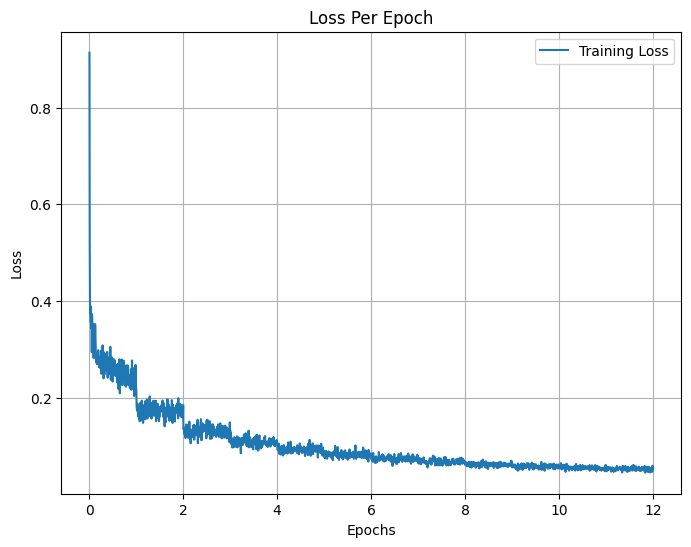

In [13]:
# Plotting loss values per epoch
plt.figure(figsize=(8, 6))
plt.plot(epoch_progress, loss_values, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Per Epoch")
plt.legend()
plt.grid()
plt.show()

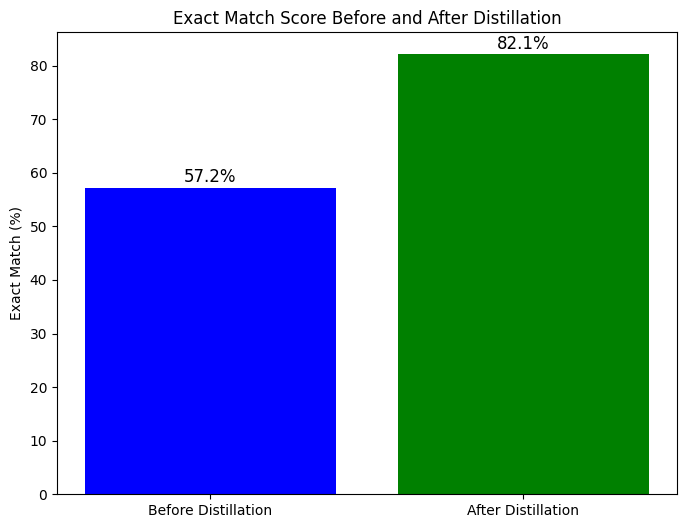

In [14]:
# Plotting Exact Match scores before and after distillation
plt.figure(figsize=(8, 6))
labels = ["Before Distillation", "After Distillation"]
exact_match_scores = [exact_match_before, exact_match_after]
plt.bar(labels, exact_match_scores, color=['blue', 'green'])
plt.ylabel("Exact Match (%)")
plt.title("Exact Match Score Before and After Distillation")
for i, v in enumerate(exact_match_scores):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
plt.show()

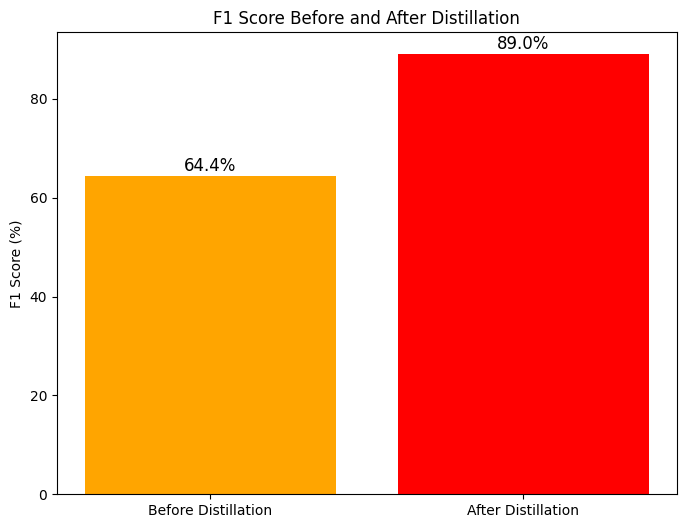

In [15]:
# Plotting F1 scores before and after distillation
plt.figure(figsize=(8, 6))
f1_scores = [f1_score_before, f1_score_after]
plt.bar(labels, f1_scores, color=['orange', 'red'])
plt.ylabel("F1 Score (%)")
plt.title("F1 Score Before and After Distillation")
for i, v in enumerate(f1_scores):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
plt.show()

In [16]:
# Save the fine-tuned model and tokenizer
student_model.save_pretrained("./distilled_model")
student_tokenizer.save_pretrained("./distilled_model")

('./distilled_model/tokenizer_config.json',
 './distilled_model/special_tokens_map.json',
 './distilled_model/vocab.json',
 './distilled_model/merges.txt',
 './distilled_model/added_tokens.json',
 './distilled_model/tokenizer.json')